# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Analyzing the given set of job descriptions and predicting the salaries for the new set of job descriptions

In [1]:
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#etc

#your info here
__author__ = "Manohar Sai Jasti"
__email__ = "jmanoharsai5@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe
def load_data(path):
    return pd.read_csv(path)
def get_summary(df):
    return df.describe(include = [np.number]), df.describe(include = ['O'])
def merge_data(train, labels, unique_identifier):
    return pd.merge(train, labels, on = unique_identifier)
def plot_size(h,w):
    return plt.gcf().set_size_inches(h, w)

In [3]:
!ls -lh data

total 269304
-rwxr-xr-x@ 1 manoharsaijasti  staff    56M Oct  8  2016 test_features.csv
-rwxr-xr-x@ 1 manoharsaijasti  staff    56M Oct  8  2016 train_features.csv
-rwxr-xr-x@ 1 manoharsaijasti  staff    20M Oct  8  2016 train_salaries.csv


In [4]:
train_features = load_data("data/train_features.csv")
test_features = load_data("data/test_features.csv")
train_salaries = load_data("data/train_salaries.csv")

In [5]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [6]:
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [7]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [8]:
category_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
numerical_cols = ['yearsExperience', 'milesFromMetropolis']

numerical_cols_summary, categorical_cols_summary = get_summary(train_features)

In [9]:
numerical_cols_summary

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [10]:
categorical_cols_summary

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362685052551,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


jobId is the only column containing all the unique values. So, it can be viewed as unique identifer for 1000000 observations

In [11]:
#Merge the features and salaries on jobId
train_df = merge_data(train_features, train_salaries, unique_identifier = 'jobId')
train_df.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

### ---- 3 Clean the data ----

In [12]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
#look for duplicate data
train_df.duplicated().sum()

0

In [13]:
test_features.duplicated().sum()

0

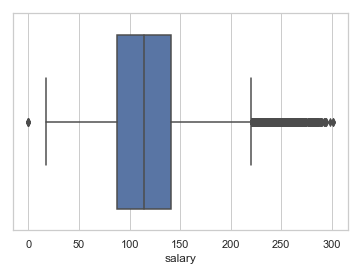

In [14]:
#look for invalid data
sns.set(style="whitegrid")
sns.boxplot(x = train_df.salary)

There exists salary amount of zero, so we will look at the data to identify what type of employees are having that salary for a better intuitive

In [15]:
#look for data where salary amount is zero
train_df[train_df.salary==0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


#categorical - major, industry
#ordinal - jobType, degree

most simplest way to encode categorical variables is - label encoding 

this works fine with trees because tree methods can split features and extract most of the useful values in categories on its own

non tree models cant use this features effectrively, knn, neural model encode variables differently 

frequency encoding - maps values to their frequencies why?preserve distributions of values and can help both tree and linear models

mean encoding uses target to generate encoding for categorical which preserves the order - best for sorted trees - gbm. mainly for classification can be used for other tasks as well. three things one has to do 1) construct encodings 2) correctly validate them 3) extend them

one hot encoding - 1 for value present 0 else , creates a sparse matrix and it becomes difficult for tree based methods, one hot encoding are already scaled b/w 0 and 1. sparse matrix is good for text methods. so linear models performs good linear model/knn -> simple and effective

numerical features preprocessing 
tree based models doesnt depend on scaling
non tree methods hugely depends on scaling


Based on the above data it looks like salary was missing for these jobId's, so these can be removed for building a better model 

In [16]:
#removing the invalid data (salaries=0)
train_df = train_df[train_df.salary>0]

In [17]:
#checking for missing data
train_df.isnull().sum().sum()

0

### ---- 4 Explore the data (EDA) ----

In [18]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [19]:
#how many employees are in the dataset after cleaning the data
train_df.shape

(999995, 9)

In [20]:
cleaned_numerical_cols_summary, cleaned_categorical_cols_summary = get_summary(train_df)

In [21]:
cleaned_numerical_cols_summary

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [22]:
cleaned_categorical_cols_summary

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362685052551,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


In [23]:
#use salary binning in to different levels(low,medium,high) to have a better understanding of the salary distribution
bins = np.linspace(min(train_df.salary), max(train_df.salary), 4)
group_names = ["Low", "Medium", "High"]
train_df["salaryBinned"]= pd.cut(train_df.salary, bins, labels = group_names, include_lowest = True)

In [24]:
price_binned_salary = train_df.groupby('salaryBinned')
price_binned_salary.mean()

,yearsExperience,milesFromMetropolis,salary
salaryBinned,,,
Low,9.754816,56.504474,83.741638
Medium,13.862790,43.799309,143.042917
High,19.272824,23.663221,222.365986


-It looks like years of experience is positively correlated with salary, as the experience increases the salary also increases. 

-milesFromMetropolis is negatively correlated with salary, the people staying in the city or closer to the working place their salary is very high compared to the people staying away from the working place

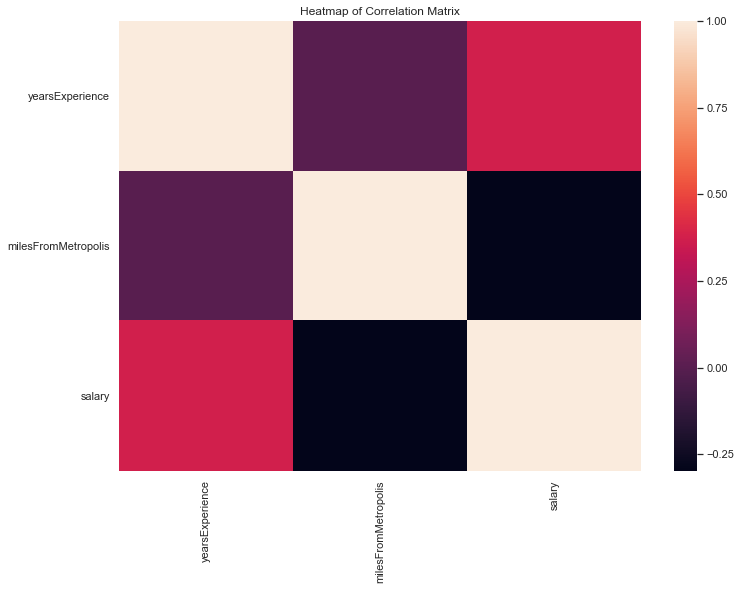

In [25]:
# Create a correlation matrix. What features correlate the most with salaries? What other correlations I find?
corr = train_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr
plt.gcf().set_size_inches(11.7, 8.27)

## Distribution of Salary, years of experience, miles from metropolis

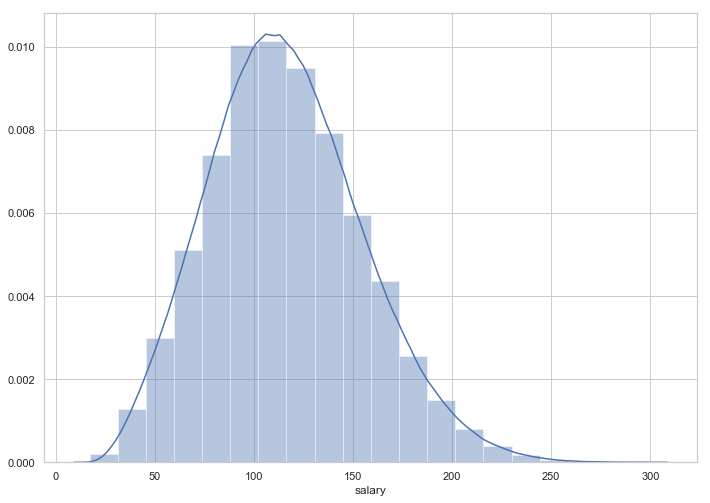

In [26]:
sns.distplot(train_df['salary'],hist=True, bins=20)
plot_size(11.7,8.27)

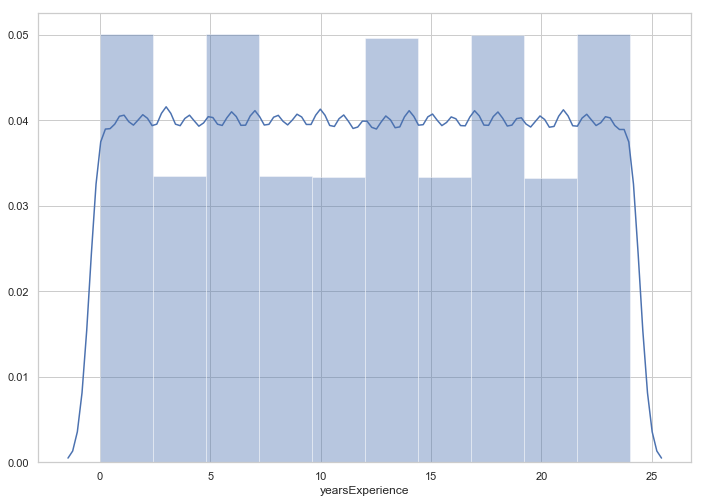

In [27]:
sns.distplot(train_df['yearsExperience'],hist=True, bins=10)
plot_size(11.7,8.27)

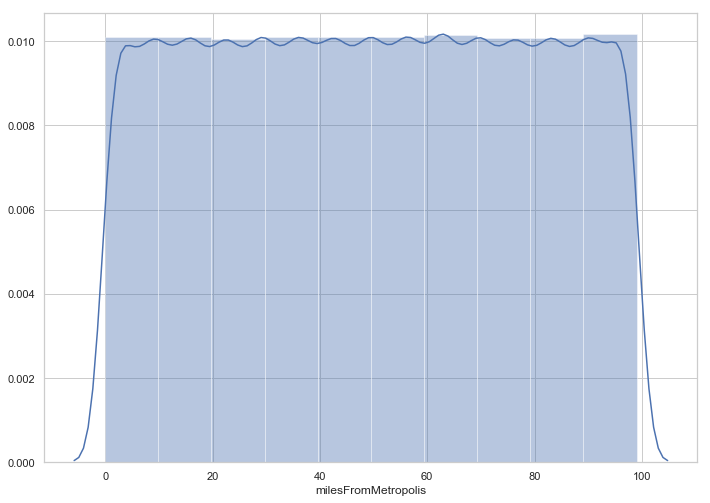

In [28]:
sns.distplot((train_df['milesFromMetropolis']),hist=True, bins=10)
plot_size(11.7,8.27)

- Salary is a normal distribution so it is easier to perform statistical operations on it

## Research Question 1: 
How does the salary and years of Experience distribute with the Industry? I believe in any industry as the experience increases salary increases. Lets see

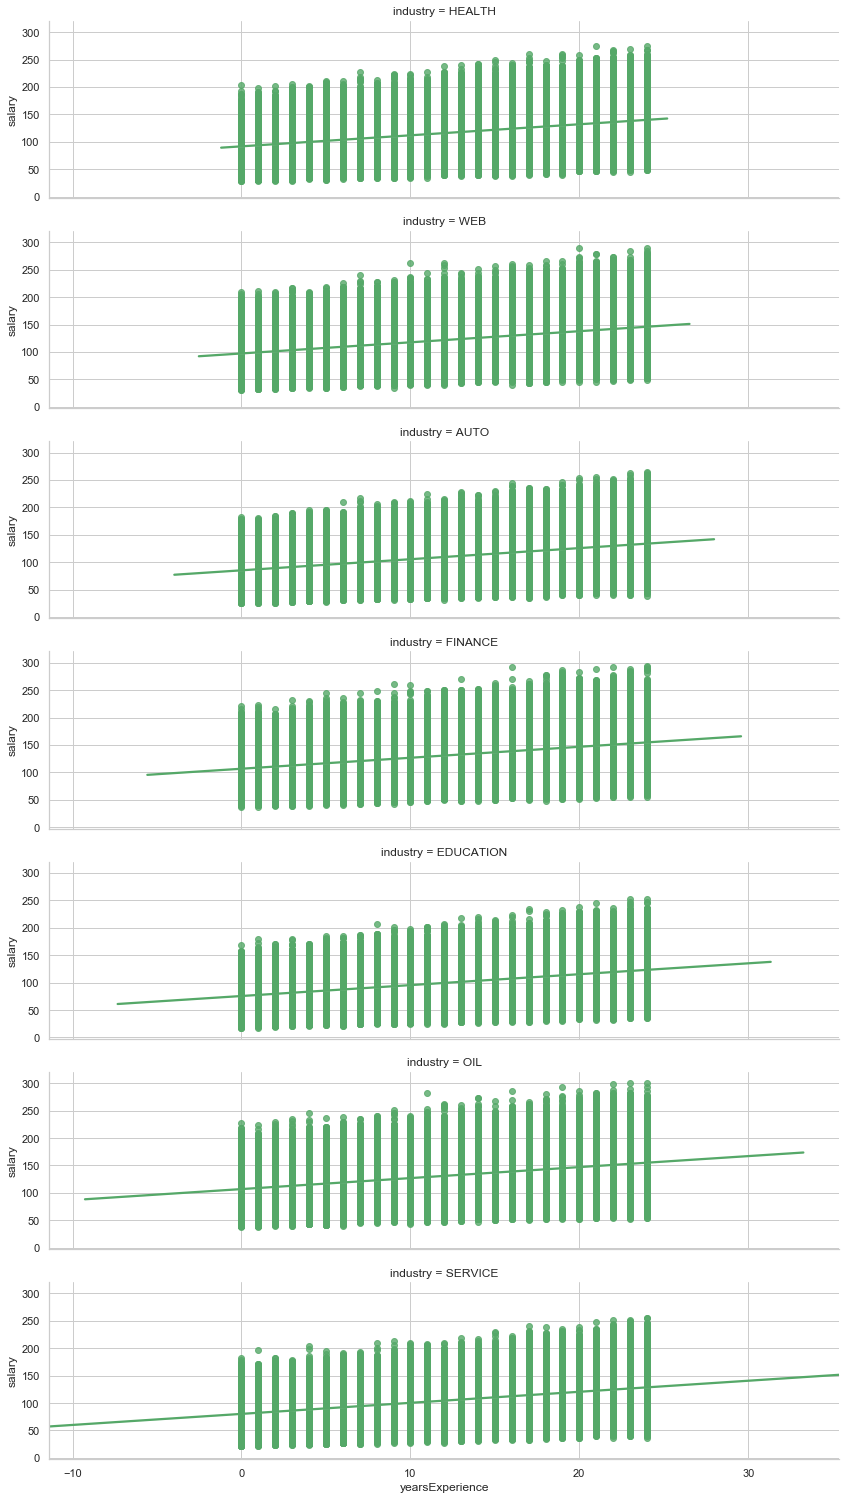

In [29]:
g = sns.FacetGrid(train_df, row="industry",  aspect= 4)
g = g.map(sns.regplot, "yearsExperience", "salary", color="g")

## Research Question 2:
Do the salary for an individual concerned with his/her major and the industry?
For example: a person with biology major earns more than a person with maths major in the healthcare industry

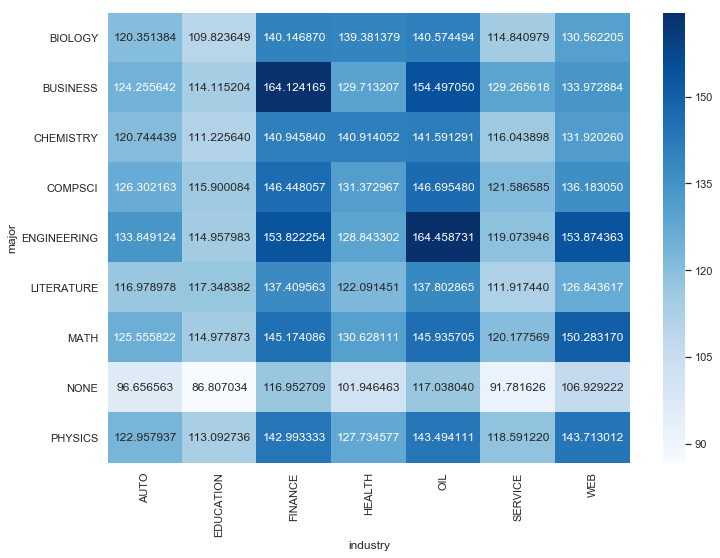

In [30]:
major_industry_salary_pivot =  train_df.pivot_table(index='major', 
                        columns='industry', 
                        values='salary')
ax = sns.heatmap(major_industry_salary_pivot, cmap="Blues", annot=True, fmt="f")
plot_size(11.7,8.27)

## Research Question 3:
Do the advanced degree alone really boosts one's salary?, I believe no, lets visualize

In [31]:
degree_salaries = train_df.groupby('degree')
degree_salaries.salary.describe()[['mean','std']]

,mean,std
degree,,
BACHELORS,125.454663,35.042720
DOCTORAL,135.490979,35.790555
HIGH_SCHOOL,101.921085,36.112684
MASTERS,130.505647,35.399830
NONE,98.176882,34.915141


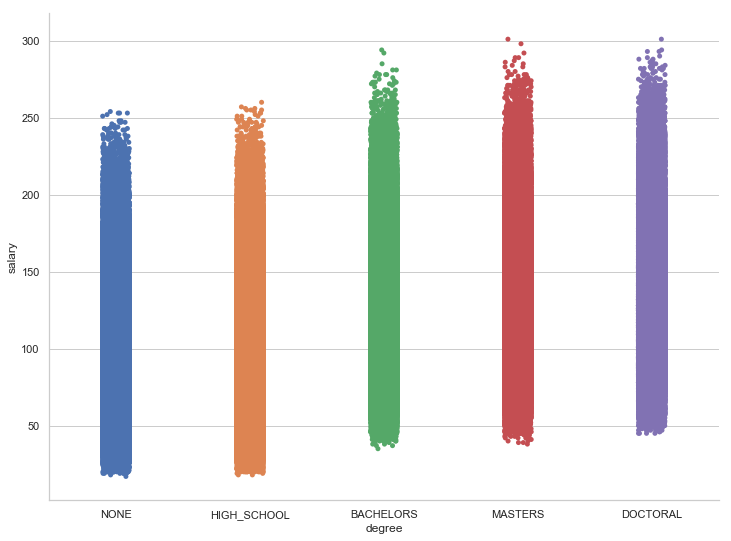

In [32]:
sns.catplot(x="degree", y="salary", order=['NONE', 'HIGH_SCHOOL', 'BACHELORS', 'MASTERS', 'DOCTORAL'], data=train_df)
plot_size(11.7,8.27)

Summary of Exploratory data analysis :
    - Oil, Finance, Health are having the highest mean salaries for their employees.
    - As the years of experience increases the salary also increases irrespective of the industry
    - Having an advanced degree doesnt boost one's salary by a huge margin since bachelors, masters and doctoral 
    degree holders share the similar salary distribution. So, there are other factors combined with degree plays a 
    keyrole in determining the salary boost for an employee eg: industry, seniority levels, major.
    - a person with biology major earns more than a person with maths major in the healthcare industry, a person with business major earns more than a person with any major in the finance industry. So, for an industry related major there is a bias towards the salary


### ---- 5 Establish a baseline ----

In [33]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

## Selecting a Performance Measure
Salary prediction is a regression problem. MSE is a reasonable metric here because when the model makes the salary predictions, RMSE gives a higher weight for large errors. 


In [34]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,salaryBinned
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,Medium
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,Low
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,Medium
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,Medium
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,Medium


In [35]:
job_desc = train_df[['yearsExperience', 'milesFromMetropolis']].copy()

In [36]:
salary_labels = train_df['salary'].copy()


## Creating a baseline linear regression model

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
lin_reg = LinearRegression()

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
lin_scores = cross_val_score(lin_reg, job_desc, salary_labels, scoring = 'neg_mean_squared_error', cv=5)

In [41]:
lin_scores

array([-1155.25446291, -1157.56791317, -1160.29179988, -1155.46219208,
       -1147.16924563])

## Plotting validation curve

Our training set has 999995 instances, so the maximum value is 999995. . We’ll do Validation using an 80:20 ratio, ending up with a training set of 799996 instances (80%), and a validation set of 199999 instances (20%). The maximum value we can use to generate our learning curves is 7654

In [42]:
train_sizes = [1, 200000, 400000, 600000, 799996]

In [43]:
from sklearn.model_selection import learning_curve

In [44]:
train_sizes, train_scores, validation_scores = learning_curve(
                                 estimator = LinearRegression(),
                                      X = job_desc,
     y = salary_labels, train_sizes = train_sizes, cv = 5,
                scoring = 'neg_mean_squared_error')

In [45]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[   -0.            -0.            -0.            -0.            -0.        ]
 [-1157.51197821 -1155.23269583 -1155.23465365 -1155.23465365
  -1155.23465365]
 [-1158.90530673 -1157.75958001 -1156.39491077 -1156.38802041
  -1156.38802041]
 [-1157.76183098 -1156.99568368 -1156.08759175 -1157.6949519  -1157.68983711]
 [-1155.11111421 -1154.53445813 -1153.85276632 -1155.05952046
  -1157.13221304]]

 ----------------------------------------------------------------------

Validation scores:

 [[-2659.44166221 -1693.61047805 -1692.59554798 -1690.48290741
  -1690.66711834]
 [-1155.30063818 -1157.58023867 -1160.30040907 -1155.47108291
  -1147.15851136]
 [-1155.27456326 -1157.5721314  -1160.29701627 -1155.47211084
  -1147.16863694]
 [-1155.26512955 -1157.56996015 -1160.28958531 -1155.46565239
  -1147.17192208]
 [-1155.25446291 -1157.56791317 -1160.29179988 -1155.46219208
  -1147.16924563]]


To plot the learning curves, we need only a single error score per training set size, not 5. For this reason, in the next code cell we take the mean value of each row and also flip the signs of the error scores.

In [46]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1           -0.000000
200000    1155.689727
400000    1157.167168
600000    1157.245979
799996    1155.138014
dtype: float64

 --------------------

Mean validation scores

 1         1885.359543
200000    1155.162176
400000    1155.156892
600000    1155.152450
799996    1155.149123
dtype: float64


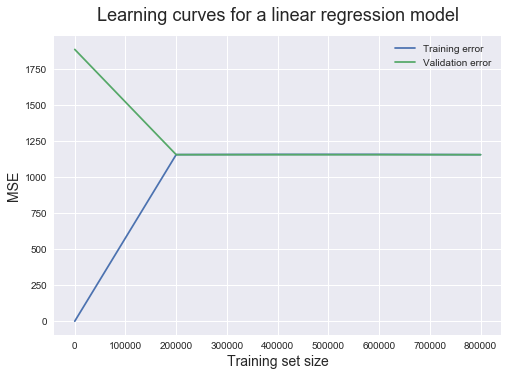

In [47]:
import matplotlib.pyplot as plt


plt.style.use('seaborn')

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

## From 200000 training data points onward, the validation MSE stays roughly the same. This tells us something extremely important: adding more training data points won’t lead to significantly better models. So instead of wasting time (and possibly money) with collecting more data, we need to try something else, like switching to an algorithm that can build more complex models.

## The model fails to fit the training data well,  Our learning algorithm suffers from high bias and low variance, underfitting the training data.

## The main options to fix this problem are:
• Selecting a more powerful model, with more parameters

• Feeding better features to the learning algorithm (feature engineering)

• Reducing the constraints on the model (e.g., reducing the regularization hyper‐ parameter)

### ---- 6 Hypothesize solution ----

#brainstorm 3 models that you think may improve results over the baseline model based

1. Random Forest Regression
2. Gradient Boosting Regression
3. Elastic net

Based on my EDA, One solution at this point is to change to a more complex learning algorithm. This should decrease the bias and increase the variance. I believe in this scenario Random Forest Regressor, Ridge Regression, Polynomial Regression will do the job for me because of the model complexity they are having.

Boosting algorithms play a crucial role in dealing with bias variance trade-off.  Unlike bagging algorithms, which only controls for high variance in a model, boosting controls both the aspects (bias & variance), and is considered to be more effective.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

During my Exploratory Data Analysis I found major, industry, and degree are positively corelated with salary. One hot encoding might help.



## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [48]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

In [49]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,salaryBinned
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,Medium
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,Low
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,Medium
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,Medium
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,Medium


## Handling Numerical, Text and Categorical Variables

In [50]:
salary = train_df.copy()
salary_desc = salary.drop(['salary',], axis = 1)
salary_labels = salary['salary'].copy()

In [51]:
salary_labels.head()

0    130
1    101
2    137
3    142
4    163
Name: salary, dtype: int64

In [52]:
salary_desc.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salaryBinned
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,Medium
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,Low
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,Medium
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,Medium
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,Medium


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

What I'd recommend now, is to rewrite your project in OOP
have a data manager class
and a model manager class

the data manager class deals with features & preprocessing -DONE

the model manager manages a list of models, cycles through them and keeps the best performing model

## the data manager class deals with features & preprocessing 

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

In [109]:
class DataManager(BaseEstimator, TransformerMixin): 
    def __init__(self, pipeline):
        self.pipeline = pipeline
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        data_prepared = self.pipeline.fit_transform(X)
        return data_prepared.toarray()


In [110]:
numer_attribs = ['yearsExperience', 'milesFromMetropolis']
categ_attribs = ['major', 'industry', 'degree', 'jobType']
DataManager_pipeline = ColumnTransformer([
        ("num", StandardScaler(), numer_attribs),
        ("ord", OneHotEncoder(), categ_attribs)
        ])

In [111]:
myDataManager = DataManager(DataManager_pipeline)

In [112]:
myDataManager.fit(train_df)

DataManager(pipeline=ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['yearsExperience', 'milesFromMetropolis']), ('ord', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True), ['major', 'industry', 'degree', 'jobType'])]))

In [113]:
salary_prepared = myDataManager.transform(salary_desc)

/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [114]:
salary_prepared

array([[-0.27624796,  1.159047  ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.24680052,  0.81275912,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.27624796, -0.39924849,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 0.55565425,  1.08978943,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.83084942, -1.54199851,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.11025571, -1.33422578,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [61]:
salary_prepared.shape

(999995, 31)

## the model manager manages a list of models, cycles through them and keeps the best performing model

In [62]:
from sklearn import model_selection

In [63]:
class ModelManager():
    def __init__(self, models,  scoring ='neg_mean_squared_error', kfold =5):
        self.models = models
        self.scoring = scoring
        self.kfold = kfold
    def fit(self, X, y):
        return self
    def transform(self, X, y):
        results = []
        names = []
        model_scoring_mean = {}
        for name, model in self.models:
            print('Managing', name)
            cv_results = model_selection.cross_val_score(model, X, y, cv=self.kfold, scoring=self.scoring)
            print('Cross Validation done, storing the results of', name)
            results.append(cv_results)
            names.append(name)
            print('Calculating and storing the mean of cv results for', name)
            model_scoring_mean[name] = cv_results.mean()
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)
        print('selecting the best model')
        best_model = max(model_scoring_mean, key=model_scoring_mean.get)  
        print(best_model, model_scoring_mean[best_model])
        

### ---- 8 Create models ----

In [64]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [65]:
models = []
#models.append(('forest_reg', RandomForestRegressor(n_estimators=10, random_state=42)))
models.append(('elastic_net', ElasticNet(alpha =0.1, l1_ratio=0.5)))
models.append(('lasso_reg', Lasso(alpha = 0.2, )))
models.append(('ridge_reg', Ridge(alpha=0.2)))
models.append(('xgbrg', XGBRegressor(learning_rate=0.2, n_estimators =300, max_depth = 5, alpha = 0.2, 
                                     min_child_weight = 5, nthread=4)
              ))

### ---- 9 Test models ----

In [66]:
#do 5-fold cross validation on models and measure MSE
scoring = 'neg_mean_squared_error'
kfold =5

In [67]:
myModelManager = ModelManager(models, scoring, kfold)

In [68]:
myModelManager.fit(salary_prepared, salary_labels)

In [69]:
myModelManager.transform(salary_prepared, salary_labels)

Managing elastic_net
Cross Validation done, storing the results of elastic_net
Calculating and storing the mean of cv results for elastic_net
elastic_net: -435.346966 (2.332580)
Managing lasso_reg
Cross Validation done, storing the results of lasso_reg
Calculating and storing the mean of cv results for lasso_reg
lasso_reg: -392.707288 (2.040534)
Managing ridge_reg
Cross Validation done, storing the results of ridge_reg
Calculating and storing the mean of cv results for ridge_reg
ridge_reg: -384.414337 (1.782021)
Managing xgbrg


/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed i

Cross Validation done, storing the results of xgbrg
Calculating and storing the mean of cv results for xgbrg
xgbrg: -356.442402 (1.486353)
selecting the best model
xgbrg -356.44240189


### ---- 10 Select best model  ----

#select the model with the lowest error as your "prodcuction" model
## XG Boost regressor is having the lowest error, we will select this as production model

In [73]:
from sklearn.model_selection import GridSearchCV
pipe_xgbrg = Pipeline([('data preprocessing',DataManager(DataManager_pipeline)),('xgbrg', XGBRegressor( n_estimators = 300,
                                                                                     
                     max_depth =5, min_child_weight = 5, nthread=4))])

In [74]:
param_grid = {
    "xgbrg__alpha": [0.4, 0.5],
    "xgbrg__learning_rate" : [0.2, 0.3]
}

In [75]:
gs_xgbrg = GridSearchCV(estimator=pipe_xgbrg,
                      param_grid=param_grid,
                      scoring='neg_mean_squared_error',cv=5, n_jobs =4) 

In [77]:
gs_xgbrg.fit(salary_desc, salary_labels)

/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('data preprocessing', DataManager(pipeline=ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['yearsExperience', 'milesFromMetropolis']), ('ord', O... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'xgbrg__alpha': [0.4, 0.5], 'xgbrg__learning_rate': [0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [78]:
gs_xgbrg.best_params_

{'xgbrg__alpha': 0.4, 'xgbrg__learning_rate': 0.2}

In [79]:
gs_xgbrg.best_score_

-356.44227963284817

In [80]:
gs_xgbrg.best_estimator_

Pipeline(memory=None,
     steps=[('data preprocessing', DataManager(pipeline=ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['yearsExperience', 'milesFromMetropolis']), ('ord', O... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))])

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset


In [81]:
my_model = gs_xgbrg.best_estimator_

In [82]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

In [83]:
my_model_loaded

Pipeline(memory=None,
     steps=[('data preprocessing', DataManager(pipeline=ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['yearsExperience', 'milesFromMetropolis']), ('ord', O... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))])

In [84]:
#Prepare Test set

In [85]:
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [127]:
myTestDataManager = my_model_loaded.named_steps['data preprocessing']

In [129]:
testDataPrepared = myTestDataManager.transform(test_features)

/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/manoharsaijasti/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [133]:
final_model = my_model_loaded.named_steps['xgbrg']

In [134]:
final_predictions = final_model.predict(testDataPrepared)

In [177]:
feature_importances = final_model.feature_importances_

31

In [240]:
cat_one_hot_attribs = DataManager_pipeline.transformers_[1][1].get_feature_names().tolist()

In [253]:
DataManager_pipeline.transformers_

[('num',
  StandardScaler(copy=True, with_mean=True, with_std=True),
  ['yearsExperience', 'milesFromMetropolis']),
 ('ord', OneHotEncoder(categorical_features=None, categories=None,
         dtype=<class 'numpy.float64'>, handle_unknown='error',
         n_values=None, sparse=True), ['major',
   'industry',
   'degree',
   'jobType']),
 ('remainder', 'drop', [0, 1])]

In [227]:
DataManager_pipeline.transformers_[1]

('ord', OneHotEncoder(categorical_features=None, categories=None,
        dtype=<class 'numpy.float64'>, handle_unknown='error',
        n_values=None, sparse=True), ['major',
  'industry',
  'degree',
  'jobType'])

In [232]:
attributes =  numerical_cols + cat_one_hot_attribs 

In [233]:
attributes

['yearsExperience',
 'milesFromMetropolis',
 'x0_BIOLOGY',
 'x0_BUSINESS',
 'x0_CHEMISTRY',
 'x0_COMPSCI',
 'x0_ENGINEERING',
 'x0_LITERATURE',
 'x0_MATH',
 'x0_NONE',
 'x0_PHYSICS',
 'x1_AUTO',
 'x1_EDUCATION',
 'x1_FINANCE',
 'x1_HEALTH',
 'x1_OIL',
 'x1_SERVICE',
 'x1_WEB',
 'x2_BACHELORS',
 'x2_DOCTORAL',
 'x2_HIGH_SCHOOL',
 'x2_MASTERS',
 'x2_NONE',
 'x3_CEO',
 'x3_CFO',
 'x3_CTO',
 'x3_JANITOR',
 'x3_JUNIOR',
 'x3_MANAGER',
 'x3_SENIOR',
 'x3_VICE_PRESIDENT']

In [236]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31957707, 'x3_JANITOR'),
 (0.094538063, 'x3_JUNIOR'),
 (0.091400787, 'x0_NONE'),
 (0.074912876, 'x3_SENIOR'),
 (0.049009766, 'x3_CEO'),
 (0.036025286, 'x3_CTO'),
 (0.033619694, 'x1_EDUCATION'),
 (0.032771457, 'x3_CFO'),
 (0.028761825, 'x1_OIL'),
 (0.027220219, 'yearsExperience'),
 (0.02567385, 'x1_FINANCE'),
 (0.025626471, 'x1_SERVICE'),
 (0.024261007, 'x2_DOCTORAL'),
 (0.02080665, 'x1_AUTO'),
 (0.01820612, 'milesFromMetropolis'),
 (0.017757526, 'x2_NONE'),
 (0.012706126, 'x0_ENGINEERING'),
 (0.011179651, 'x1_WEB'),
 (0.010391989, 'x3_VICE_PRESIDENT'),
 (0.0091900509, 'x0_BUSINESS'),
 (0.0089124693, 'x3_MANAGER'),
 (0.0083819246, 'x2_MASTERS'),
 (0.0054908623, 'x0_LITERATURE'),
 (0.0037054708, 'x0_MATH'),
 (0.002482383, 'x1_HEALTH'),
 (0.0020032662, 'x2_HIGH_SCHOOL'),
 (0.00171179, 'x0_CHEMISTRY'),
 (0.0014756623, 'x0_BIOLOGY'),
 (0.00089794688, 'x2_BACHELORS'),
 (0.00078368658, 'x0_PHYSICS'),
 (0.00051803549, 'x0_COMPSCI')]

In [241]:
feature_importances = pd.DataFrame({'importance': feature_importances, 'attributes':attributes})

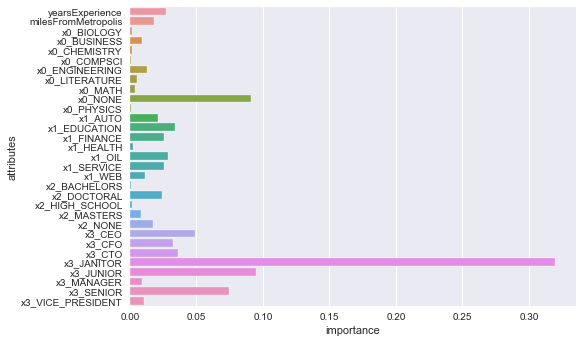

In [243]:
ax = sns.barplot(x="importance", y="attributes", data=feature_importances)

In [ ]:
class FeatureImportance():
    def __init__(self, pipeline):
        self.pipeline = pipeline
    def get_features():
        
        

In [244]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]


### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data